### Explanation for Graph Classification

In this notebook, we test the Consistency of explanations - if inputs are identical, then we expect the explanations to be identical 

### Approach 1: Running the explainer twice on the same data
We have ran the explainer for the same set of graphs twice and we have the explanations of each round in separate csv files. First we load these files into two datatframes

In [1]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
df1 = pd.read_csv("syn6_round1.csv",usecols=["Weights of regression","Bias of regression"])
df2 = pd.read_csv("syn6_round2.csv",usecols=["Weights of regression","Bias of regression"])

In [3]:
def convert_to_numpy(d):
    """The first column in both dataframes are arrays but saved as a string.
    This function converts it to a float array

    Args:
        d (str): array of weights stored in csv as string

    Returns:
        List: array of weights
    """
    s = d.split(']')
    s = s[0].split()
    s = s[1:]
    a = []

    for c in s:
        if c != '[' and c!=']':
            a.append(float(c))
    return a

Now that we have loaded the data, now we wish to measure the how close the explanations are. For this we first give some notations:

- a1: numpy array of weights along bias of regression from df1
- a2: numpy array of weights along bias of regression from df2

Next, to quantify this closeness, similar to the coherence we define the following metric

![alt text](consistency_formula.png "Title")


In [4]:
def normalize(A):
    """Normalize array A

    Args:
        A (numpy array): array to normalize

    Returns:
        numpy array: normalized array
    """
    scale_factor = A.max() - A.min()
    B = np.ones_like(A)*A.min()

    A = (A - B)/scale_factor
    return A

In [5]:
def prep_vector(df_str,i):
    """Prepare vector for further calculations

    Args:
        df_str (str): Indicates name of dataframe
        i (int): Index in the datafram

    Returns:
        numpy array: array of weights along with the bias
    """
    df = eval(df_str)      # Get the dataframe df1 or df2
    a = convert_to_numpy(df['Weights of regression'][i])
    a.append(df["Bias of regression"][i])
    a = np.array(a)
    a = np.reshape(a, (a.shape[0],-1))

    return a

In [6]:
# Compute Closeness in Approach 1
closeness1 = []
for i in range(len(df1)):
    # Form numpy arrays a1 and a2 by appending corresponding biases to the list of weights
    a1 = prep_vector('df1',i)
    a2 = prep_vector('df2',i)

    # print(f"a1: {a1}")
    # print(f"a2: {a2}")
    # Normalize the vectors
    a1 = normalize(a1)
    a2 = normalize(a2)

    # Evaluating the required metric
    a = (np.linalg.norm(a1 - a2, 2)**2)

    closeness1.append(2/(1 + math.exp(a)))

closeness1 = np.array(closeness1)
mean = np.mean(closeness1)
std = np.std(closeness1)

print(f"Closeness: {mean} +/- {std}")


Closeness: 1.0 +/- 0.0


### Approach 2: Generating explanation twice for each graph in same run

In this approach, instead of modifying the dataset by duplicating graphs to save on memory space, we just ran the explainer twice on each datapoint.

In [7]:
df3 = pd.read_csv("syn6_paired_up.csv",usecols=["Weights of regression","Bias of regression","Graph_index"])
df3.head()

,Weights of regression,Bias of regression,Graph_index
0,[ 0.1182967 -0.06619944 -0.06615967 -0.066221...,0.019828,400
1,[ 0.12056437 -0.06465124 -0.06511539 -0.064808...,0.019828,405
2,[-0.00020728 -0.00064431 0.00040602 0.000470...,0.980128,410
3,[ 0.12059369 -0.06605376 -0.06632915 -0.066331...,0.019828,415
4,[5.8056525e-04 1.7673429e-04 1.7879589e-05 7.0...,0.980128,420


We split the dataframe into two smaller frames so that the ```Graph_index``` column is unique

In [8]:
d1 = df3[:60]
d2 = df3[60:]

# Making Graph_index as the dataframe index
d1 = d1.set_index('Graph_index')
d2 = d2.set_index('Graph_index')

In [9]:
# Compute Closeness in Approach 2
closeness2 = []
for i in range(400,700,5):
    # Form numpy arrays a1 and a2 by appending corresponding biases to the list of weights
    a1 = prep_vector('d1',i)
    a2 = prep_vector('d2',i)

    # print(f"a1: {a1}")
    # print(f"a2: {a2}")
    # Normalize the vectors
    a1 = normalize(a1)
    a2 = normalize(a2)

    # Evaluating the required metric
    a = (np.linalg.norm(a1 - a2, 2)**2)

    closeness2.append(2/(1 + math.exp(a)))

closeness2 = np.array(closeness2)
mean = np.mean(closeness2)
std = np.std(closeness2)

print(f"Closeness: {mean} +/- {std}")

Closeness: 0.9999995408240712 +/- 1.9098544158613855e-06


In [10]:
for i in range(len(closeness2)):
    if closeness2[i] < 0.9999999:
        print(i)

closeness2[18]

16
18
21
24
29
30
39
40
42
45
51
53


0.9999981679136755

So, here we see that in the same run for identical inputs there is a bit of difference in the explanations, although not very significant, unlike in Approach 1 where there were no difference in the explanations generated in giving the same input twice.

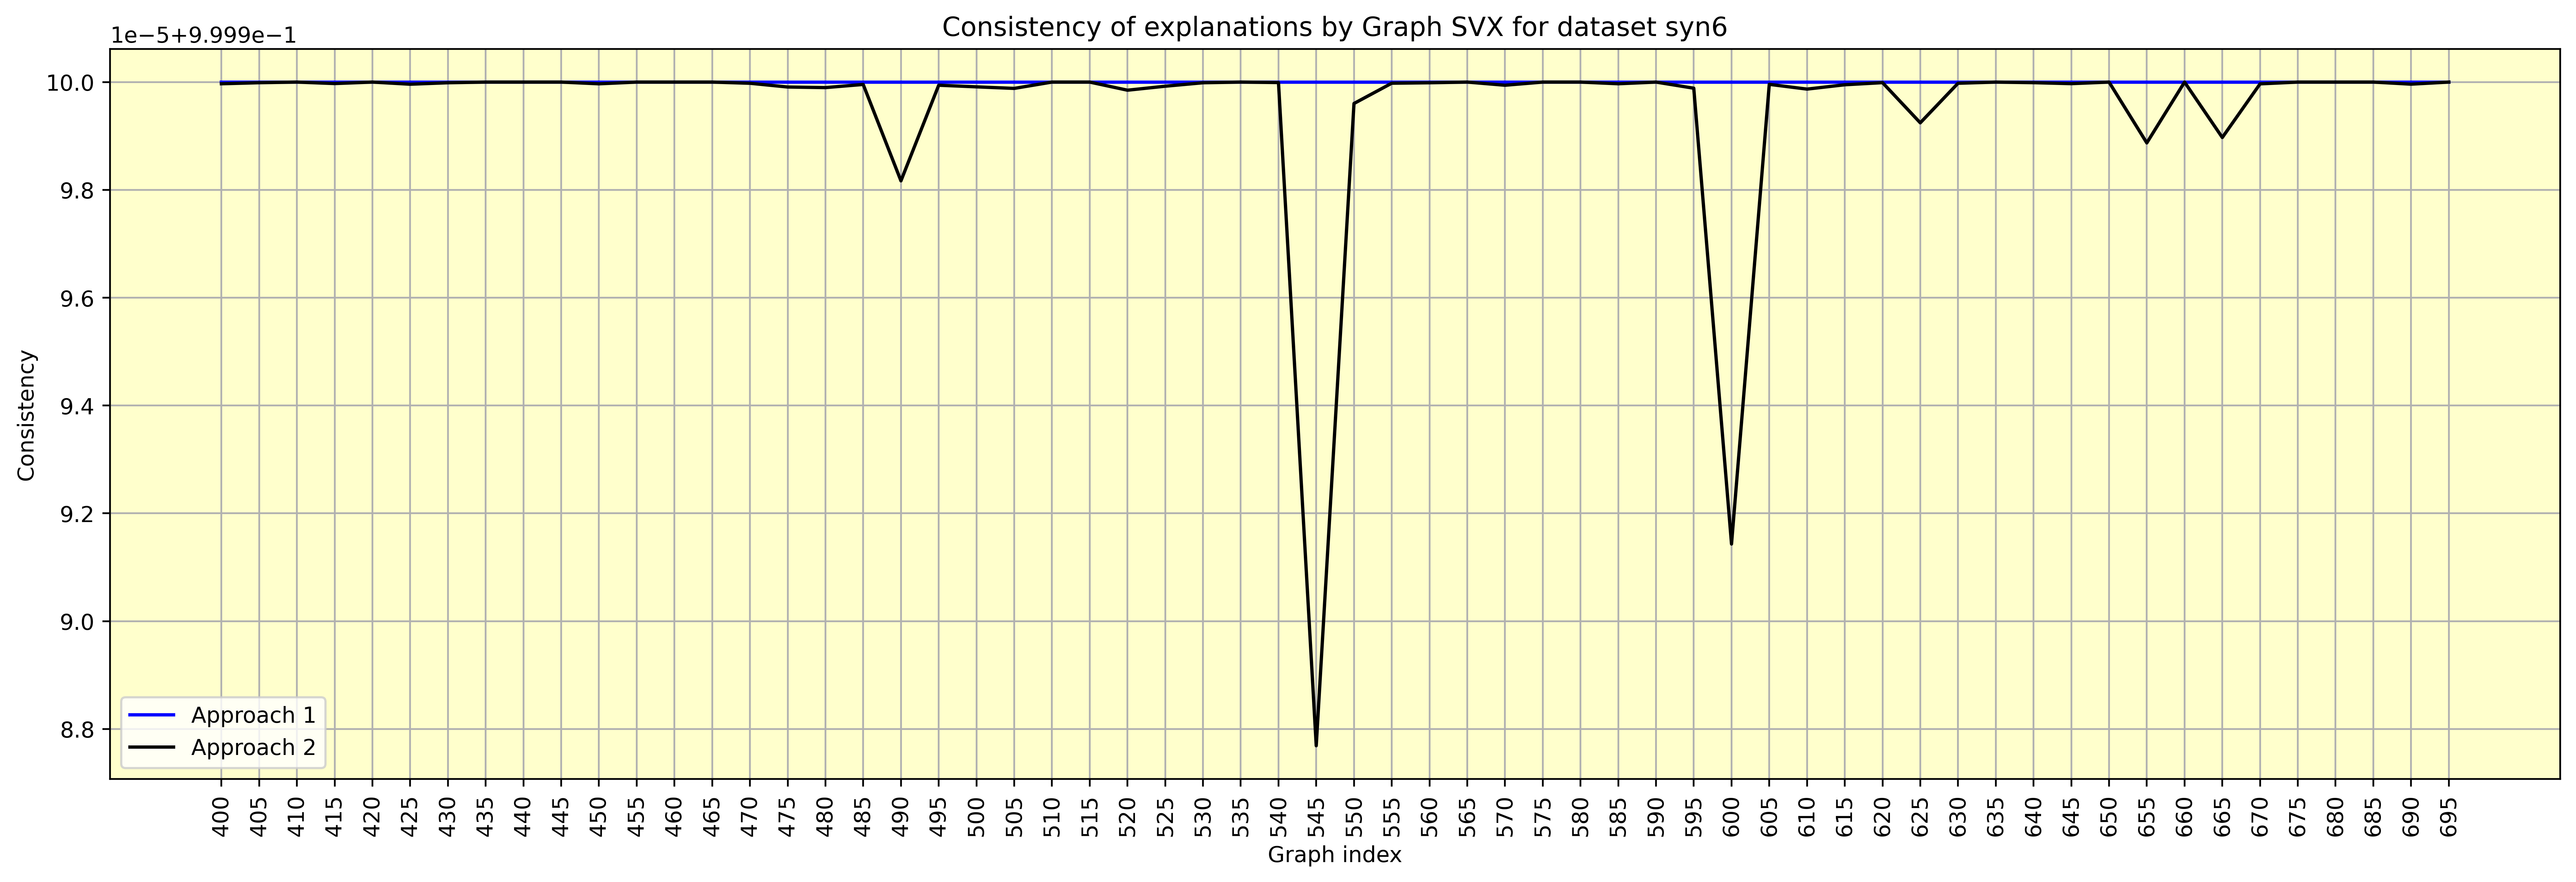

In [11]:
# Plot closeness
x = list(range(400,700,5))
y1 = list(closeness1)
y2 = list(closeness2)

plt.figure(figsize=(20,6), dpi = 500)
plt.gca().grid(True)
plt.gca().set_facecolor((1, 1, 0.8))
plt.plot(x, y1, label='Approach 1',color='blue')
plt.plot(x, y2, label='Approach 2',color='k')

plt.title('Consistency of explanations by Graph SVX for dataset syn6', fontsize=12)
plt.legend(prop={'size':10})
plt.ylabel("Consistency")
plt.xlabel("Graph index")
plt.xticks(x,rotation=90)
plt.savefig(fname= "D:\D_Drive\Github\Thesis\GraphSVX_graph_properties\graph_theoretic_properties\plots\SVX_consistency_syn6")
plt.show()

### Approach 3

In [12]:
data_id = pd.read_csv("syn6_id_a.csv",usecols=["Data index","Weights of regression","Bias of regression","Graph_index"])
data_sim = pd.read_csv("syn6_sim_fin.csv",usecols=["Data index","Weights of regression","Bias of regression","Graph_index"])

In [13]:
def make_equal_size(arr1, arr2):
    a = [arr1, arr2]
    i = 0 if arr1.shape[0] < arr2.shape[0] else 1       # index of shorter array
    j = 1 - i      # index of longer array

    to_drop = a[j].shape[0] - a[i].shape[0]       # large has to_drop elements more than small
    a[j] = a[j][:-to_drop][:]     # Array with the last to_drop elements dropped

    return a[0], a[1]

In [14]:
from types import SimpleNamespace
import pickle as pkl
def measure_closeness_inputs(filename, indices):
    data = SimpleNamespace()
    file = '../data/' + filename + '.pkl'
    with open(file, 'rb') as fin:
        data.indices, data.edge_index, data.x, data.y = pkl.load(fin)
    
    # Get the indices we need
    to_check = [x for x in indices if x%2==0]
    to_check = list(np.repeat(np.array(to_check),2))

    # Collect the required adjacency matrices
    mat1 = []
    mat2 = []
    for i in range(len(data.indices)):
        if i%2==0 and data.indices[i] in to_check:
            mat1.append(data.edge_index[i])
        elif data.indices[i] in to_check:
            mat2.append(data.edge_index[i])
    
    closeness_in = []
    # Now measure closeness
    for i in range(len(mat1)):
        # Normalize the vectors
        a1 = mat1[i]
        a2 = mat2[i]

        # Evaluating the required metric
        a = (np.linalg.norm(a1 - a2, 2)**2)

        closeness_in.append(2/(1 + math.exp(a)))

    closeness_in = np.array(closeness_in)
    # mean = np.mean(closeness_in)
    # std = np.std(closeness_in)

    # print(f"Closeness of explanations: {mean} +/- {std}")
    return closeness_in
        

# measure_closeness_inputs('syn6_similar_1',[x for x in range(400, 698) if x % 4 == 0 or x % 4 == 1])

In [15]:
# Identical pairs analysis

# Split the dataframes
data_id1 = data_id[data_id['Graph_index'] % 2==0]
data_id2 = data_id[data_id['Graph_index'] % 2==1]

# Modify indices
data_id1 = data_id1.set_index('Data index')
data_id2 = data_id2.set_index('Data index')

# Calculate closeness
closeness_out_id = []
indices = range(len(data_id1))
# indices = list(range(1))
for i in indices:
    # Form numpy arrays a1 and a2 by appending corresponding biases to the list of weights
    a1 = prep_vector('data_id1',i)
    a2 = prep_vector('data_id2',i)
    
    # Make the vectors of equal size
    if a1.shape != a2.shape:
        a1, a2 = make_equal_size(a1,a2)

    # Normalize the vectors
    a1 = normalize(a1)
    a2 = normalize(a2)

    # Evaluating the required metric
    a = (np.linalg.norm(a1 - a2, 2)**2)

    closeness_out_id.append(2/(1 + math.exp(a)))

closeness_out_id = np.array(closeness_out_id)
closeness_in_id = measure_closeness_inputs('syn6_identical',[x for x in range(400, 698) if x % 4 == 0 or x % 4 == 1])
diff_id = np.abs(closeness_in_id - closeness_out_id)
# mean = np.mean(closeness_out_id)
# std = np.std(closeness_out_id)

# print(f"Closeness of explanations: {mean} +/- {std}")
eop = np.linalg.norm(closeness_in_id - closeness_out_id,2)
eop

6.33593831408398

In [16]:
# Similar pairs analysis

# Split the dataframes
data_sim1 = data_sim[data_sim['Graph_index'] % 2==0]
data_sim2 = data_sim[data_sim['Graph_index'] % 2==1]

# Modify indices
data_sim1 = data_sim1.set_index('Data index')
data_sim2 = data_sim2.set_index('Data index')

# Calculate closeness
closeness_out_sim = []
indices = range(len(data_sim1))
# indices = list(range(1))
for i in indices:
    # Form numpy arrays a1 and a2 by appending corresponding biases to the list of weights
    a1 = prep_vector('data_sim1',i)
    a2 = prep_vector('data_sim2',i)

    # Make the vectors of equal size
    if a1.shape != a2.shape:
        a1, a2 = make_equal_size(a1,a2)

    # Normalize the vectors
    a1 = normalize(a1)
    a2 = normalize(a2)

    # Evaluating the required metric
    a = (np.linalg.norm(a1 - a2, 2)**2)

    closeness_out_sim.append(2/(1 + math.exp(a)))

closeness_out_sim = np.array(closeness_out_sim)
closeness_in_sim = measure_closeness_inputs('syn6_similar_1',[x for x in range(400, 698) if x % 4 == 0 or x % 4 == 1])
diff_sim = np.abs(closeness_in_sim - closeness_out_sim)
# mean = np.mean(closeness_out_sim)
# std = np.std(closeness_out_sim)

# print(f"Closeness: {mean} +/- {std}")
eop = np.linalg.norm(closeness_in_sim - closeness_out_sim,2)
eop

5.025456820228748

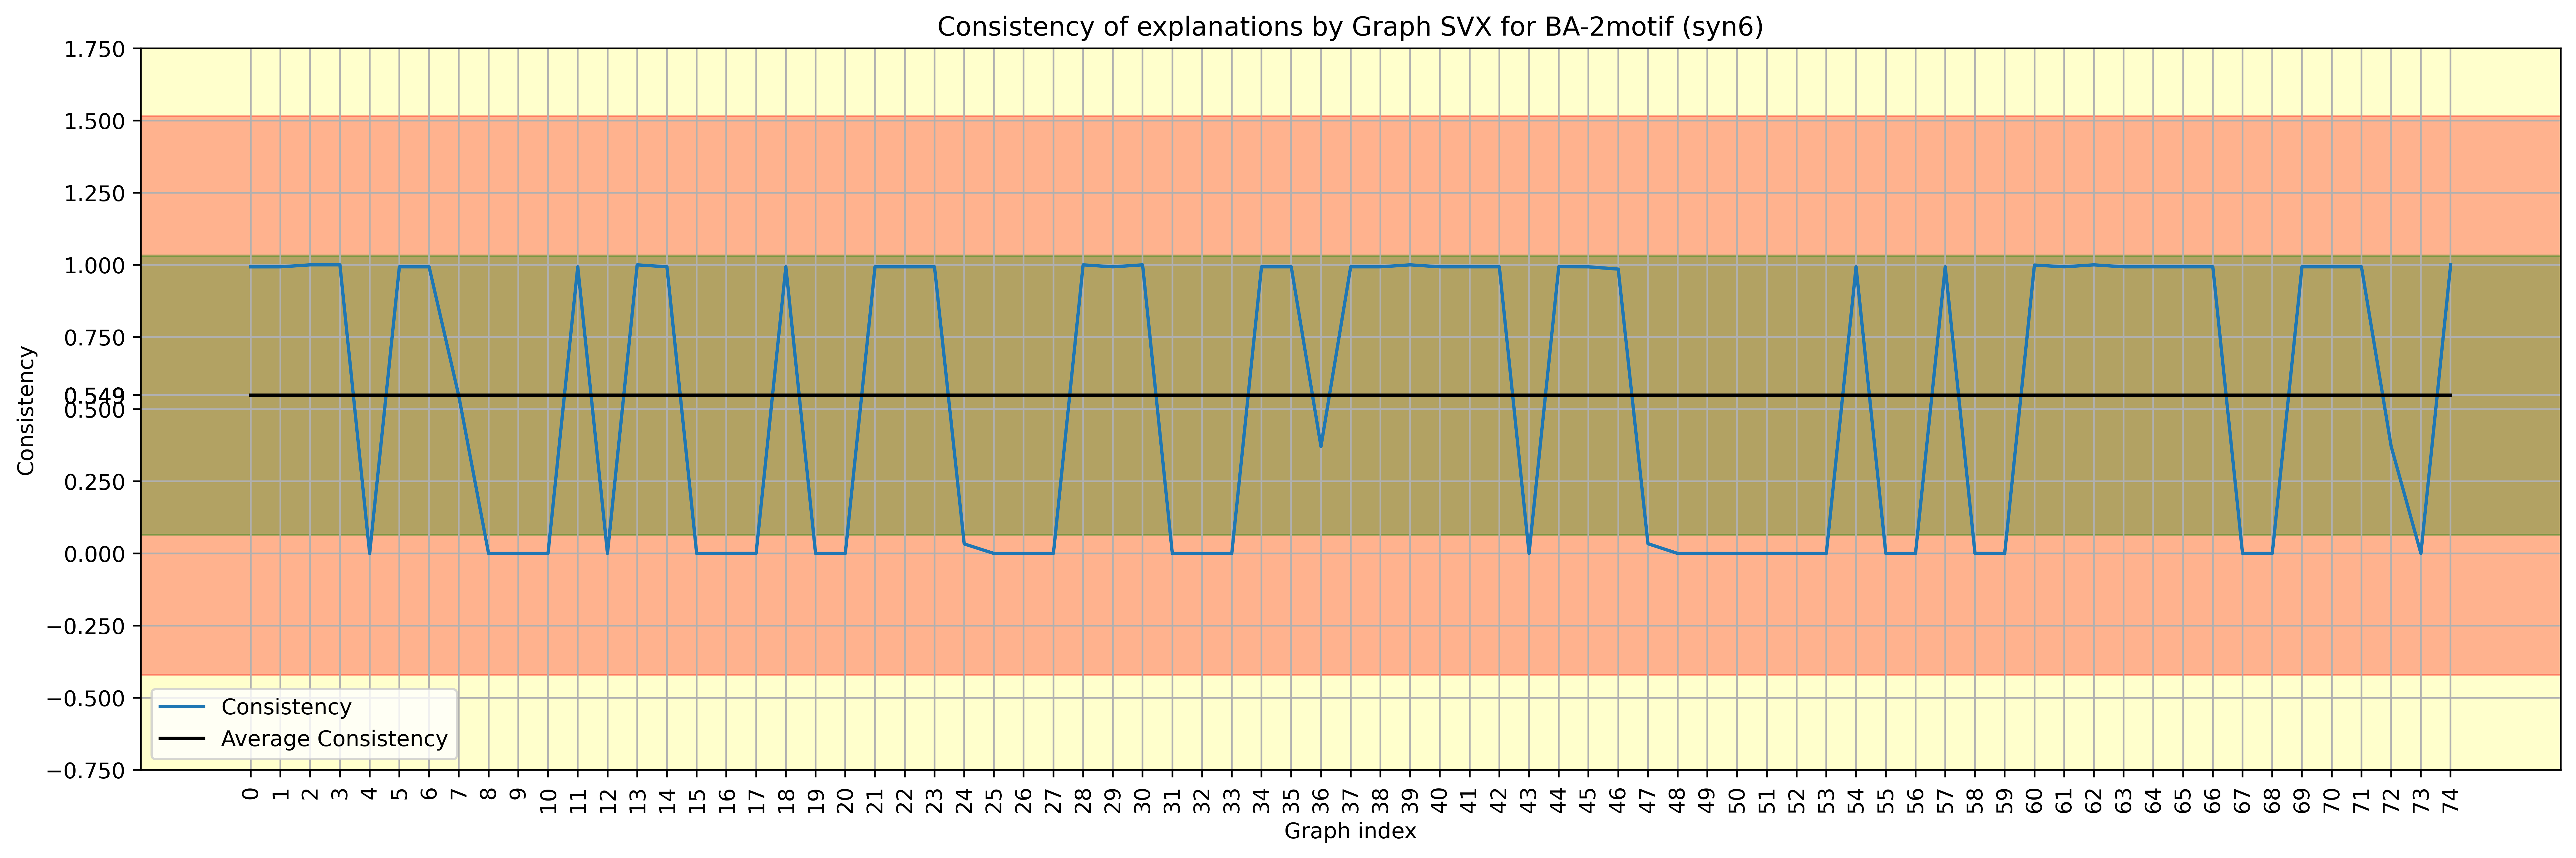

In [17]:
# Identical
x = list(range(len(diff_id)))
y = list(diff_id)
mean_id = list(np.ones(len(diff_id))*diff_id.mean())

plt.figure(figsize=(20,6), dpi = 500)
plt.gca().grid(True)
plt.gca().set_facecolor((1, 1, 0.8))
plt.plot(x, y, label='Consistency')
plt.plot(x,mean_id, label = 'Average Consistency', color='k')

mean = diff_id.mean()
std = diff_id.std()
y1 = mean - std
y_1 = y1 - std
y2 = mean + std
y_2 = y2 + std
plt.axhspan(y_1, y_2, color='red', alpha=0.3)
plt.axhspan(y1, y2, color='green', alpha=0.3)

plt.title('Consistency of explanations by Graph SVX for BA-2motif (syn6)', fontsize=12)
plt.legend(prop={'size':10})
plt.ylabel("Consistency")
plt.xlabel("Graph index")
plt.xticks(x,rotation=90)
plt.yticks(list(plt.yticks()[0]) + mean_id)
plt.savefig(fname= "D:\D_Drive\Github\Thesis\GraphSVX_graph_properties\graph_theoretic_properties\plots\SVX_consistency_syn6_id")
plt.show()

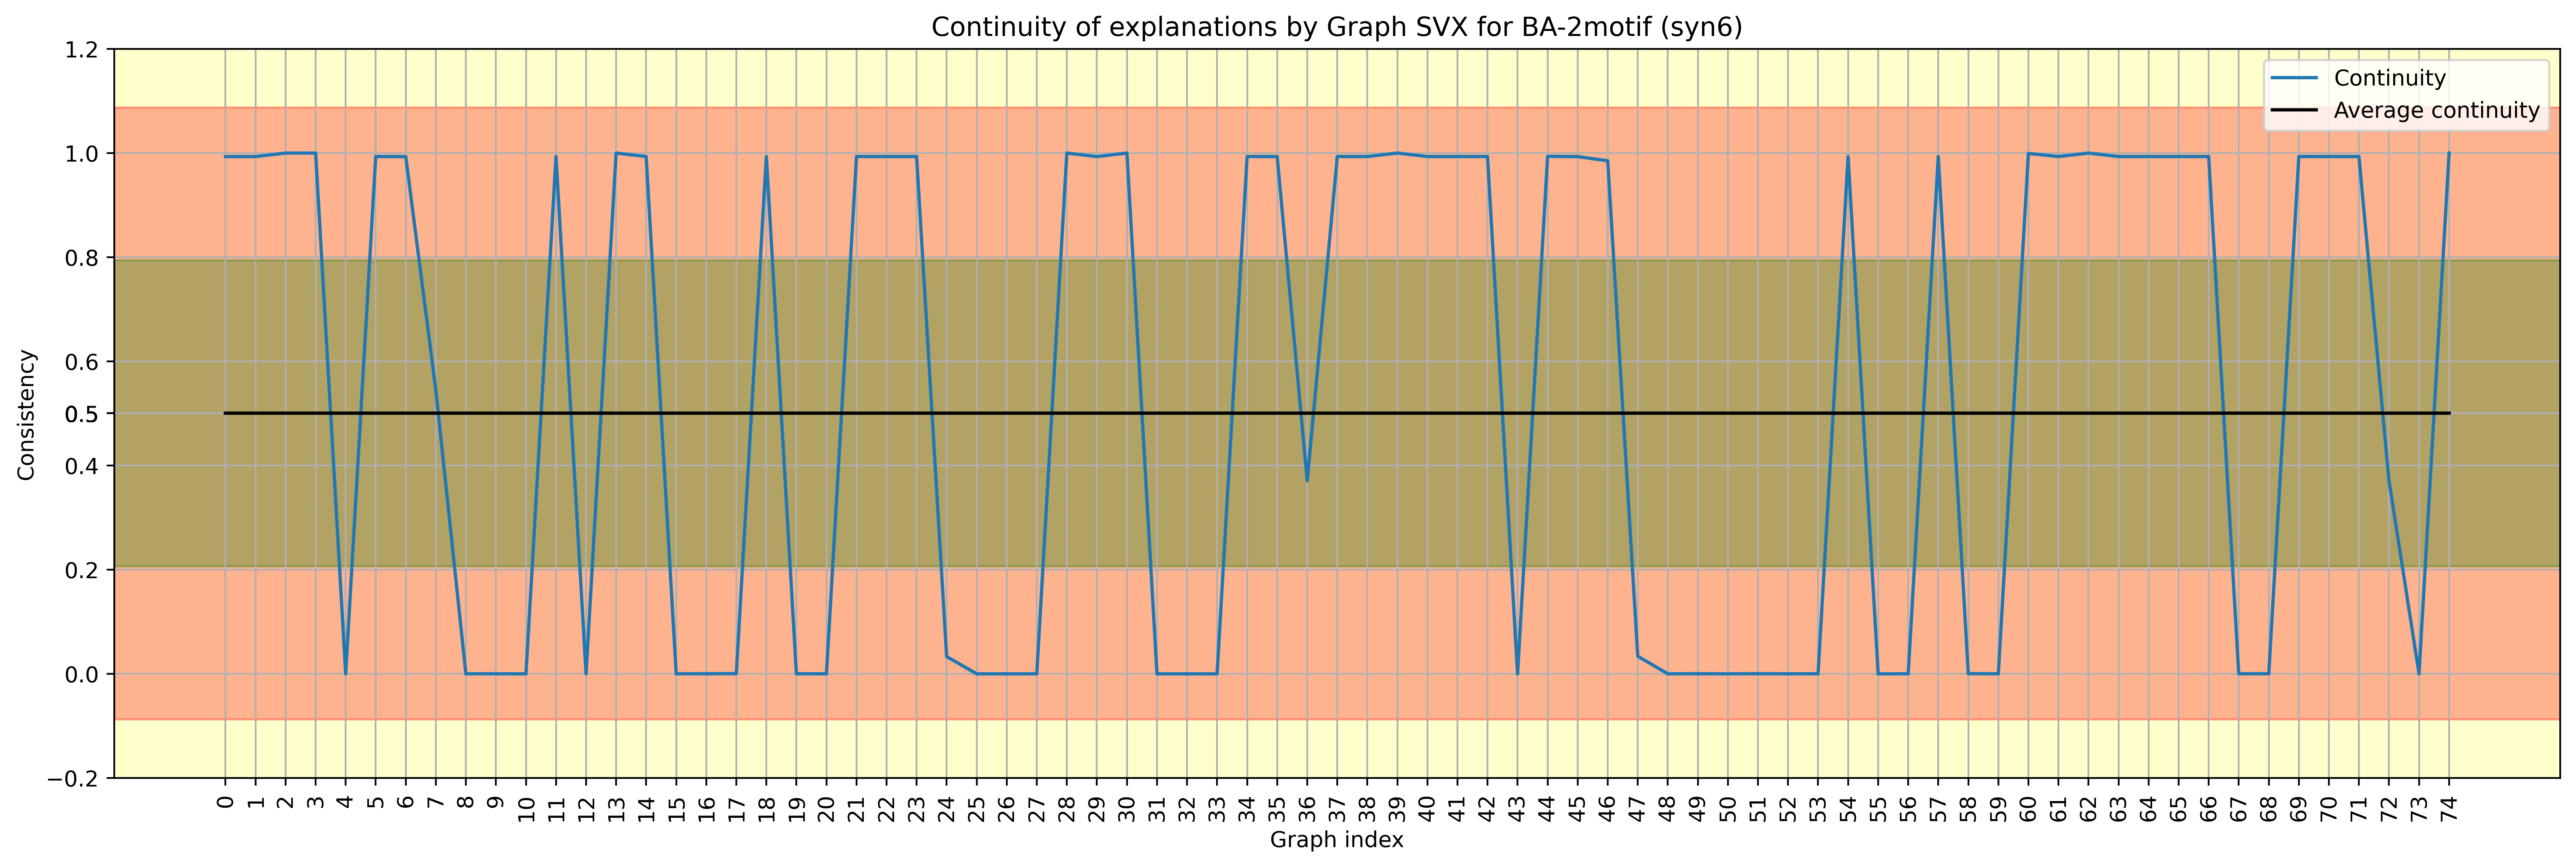

In [18]:
# Similar
x = list(range(len(diff_sim)))
y = list(diff_id)
mean_sim = list(np.ones(len(diff_sim))*diff_sim.mean())

plt.figure(figsize=(20,6), dpi = 500)
plt.gca().grid(True)
plt.gca().set_facecolor((1, 1, 0.8))
plt.plot(x, y, label='Continuity')
plt.plot(x,mean_sim, label = 'Average continuity', color='k')

mean = diff_sim.mean()
std = diff_sim.std()
y1 = mean - std
y_1 = y1 - std
y2 = mean + std
y_2 = y2 + std
plt.axhspan(y_1, y_2, color='red', alpha=0.3)
plt.axhspan(y1, y2, color='green', alpha=0.3)

plt.title('Continuity of explanations by Graph SVX for BA-2motif (syn6)', fontsize=12)
plt.legend(prop={'size':10})
plt.ylabel("Consistency")
plt.xlabel("Graph index")
plt.xticks(x,rotation=90)
plt.yticks(list(plt.yticks()[0]) + mean_sim)
plt.savefig(fname= "D:\D_Drive\Github\Thesis\GraphSVX_graph_properties\graph_theoretic_properties\plots\SVX_consistency_syn6_sim")
plt.show()

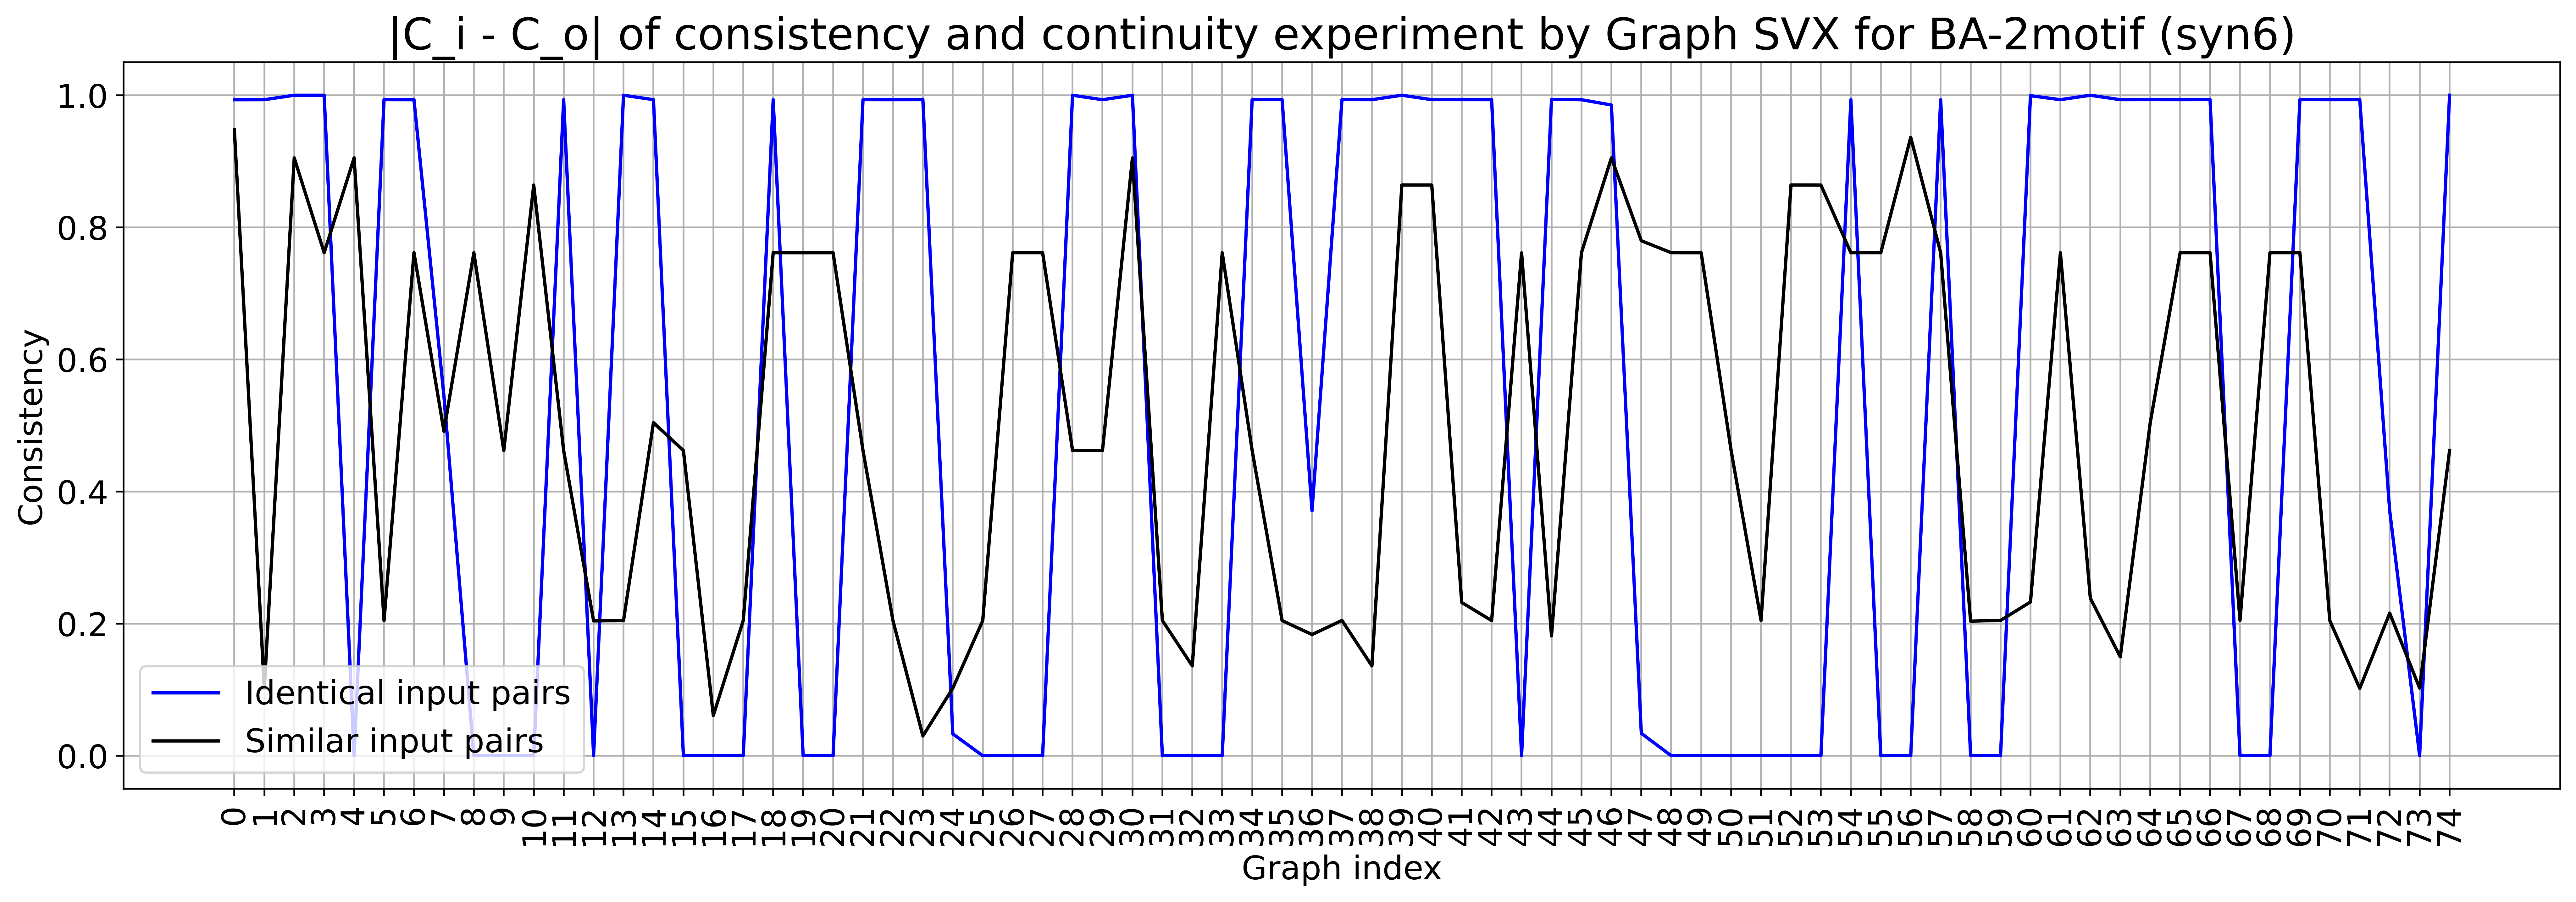

In [22]:
# Plot closeness
x = list(range(len(closeness_out_id)))
y1 = list(diff_id)
y2 = list(diff_sim)

plt.figure(figsize=(20,6), dpi = 500)
plt.gca().grid(True)
# plt.gca().set_facecolor((1, 1, 0.8))
plt.plot(x, y1, label='Identical input pairs',color='b')
plt.plot(x, y2, label='Similar input pairs',color='k')

plt.title('|C_i - C_o| of consistency and continuity experiment by Graph SVX for BA-2motif (syn6)', fontsize=20)
plt.legend(loc="lower left",fontsize=15)
plt.ylabel("Consistency",fontsize=15)
plt.xlabel("Graph index",fontsize=15)
plt.xticks(x,rotation=90,fontsize=15)
plt.yticks(fontsize=15)
plt.savefig(fname= "D:\D_Drive\BITS_Pilani\Year_5(2023-24)\\5_2\After_allotment\Thesis_paper\\thesis_plots\SVX_consistency_syn6_id_sim")
plt.show()